# FLIP (05) Learning Theory (II)

---
Team Director: Ye Lei | ylei@tulip.academy<br />

TULIP Academy <br />
http://www.tulip.academy

---


==========================================================
Comparison of kernel ridge and Gaussian process regression
==========================================================
Both kernel ridge regression (KRR) and Gaussian process regression (GPR) learn
a target function by employing internally the "kernel trick". KRR learns a
linear function in the space induced by the respective kernel which corresponds
to a non-linear function in the original space. The linear function in the
kernel space is chosen based on the mean-squared error loss with
ridge regularization. GPR uses the kernel to define the covariance of
a prior distribution over the target functions and uses the observed training
data to define a likelihood function. Based on Bayes theorem, a (Gaussian)
posterior distribution over target functions is defined, whose mean is used
for prediction.
A major difference is that GPR can choose the kernel's hyperparameters based
on gradient-ascent on the marginal likelihood function while KRR needs to
perform a grid search on a cross-validated loss function (mean-squared error
loss). A further difference is that GPR learns a generative, probabilistic
model of the target function and can thus provide meaningful confidence
intervals and posterior samples along with the predictions while KRR only
provides predictions.
This example illustrates both methods on an artificial dataset, which
consists of a sinusoidal target function and strong noise. The figure compares
the learned model of KRR and GPR based on a ExpSineSquared kernel, which is
suited for learning periodic functions. The kernel's hyperparameters control
the smoothness (l) and periodicity of the kernel (p). Moreover, the noise level
of the data is learned explicitly by GPR by an additional WhiteKernel component
in the kernel and by the regularization parameter alpha of KRR.
The figure shows that both methods learn reasonable models of the target
function. GPR correctly identifies the periodicity of the function to be
roughly 2*pi (6.28), while KRR chooses the doubled periodicity 4*pi. Besides
that, GPR provides reasonable confidence bounds on the prediction which are not
available for KRR. A major difference between the two methods is the time
required for fitting and predicting: while fitting KRR is fast in principle,
the grid-search for hyperparameter optimization scales exponentially with the
number of hyperparameters ("curse of dimensionality"). The gradient-based
optimization of the parameters in GPR does not suffer from this exponential
scaling and is thus considerable faster on this example with 3-dimensional
hyperparameter space. The time for predicting is similar; however, generating
the variance of the predictive distribution of GPR takes considerable longer
than just predicting the mean.



In [2]:
%matplotlib inline

Time for KRR fitting: 5.071
Time for GPR fitting: 0.176
Time for KRR prediction: 0.067
Time for GPR prediction: 0.084
Time for GPR prediction with standard-deviation: 0.110


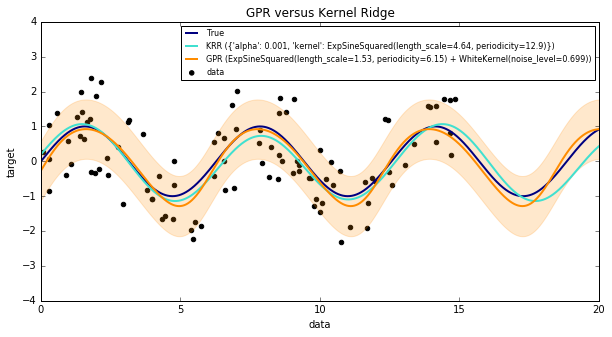

In [3]:
import time

import numpy as np

import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = np.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

# Fit KernelRidge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
stime = time.time()
kr.fit(X, y)
print("Time for KRR fitting: %.3f" % (time.time() - stime))

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) \
    + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
stime = time.time()
gpr.fit(X, y)
print("Time for GPR fitting: %.3f" % (time.time() - stime))

# Predict using kernel ridge
X_plot = np.linspace(0, 20, 10000)[:, None]
stime = time.time()
y_kr = kr.predict(X_plot)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

# Predict using gaussian process regressor
stime = time.time()
y_gpr = gpr.predict(X_plot, return_std=False)
print("Time for GPR prediction: %.3f" % (time.time() - stime))

stime = time.time()
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
print("Time for GPR prediction with standard-deviation: %.3f"
      % (time.time() - stime))

# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')
plt.plot(X_plot, y_kr, color='turquoise', lw=lw,
         label='KRR (%s)' % kr.best_params_)
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.title('GPR versus Kernel Ridge')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()